In [179]:
import pandas as pd
import numpy as np
import pandas as pd
import re
import os

def convert_time(time_str):
    # Regular expression to match the time components
    pattern = re.compile(r'((?P<hours>\d+(\.\d+)?)h)?\s*((?P<minutes>\d+(\.\d+)?)m)?\s*((?P<seconds>\d+(\.\d+)?)s)?\s*((?P<milliseconds>\d+(\.\d+)?)ms)?')
    match = pattern.fullmatch(time_str.strip())

    if not match:
        print(time_str)
        raise ValueError("Time string is not in the correct format")

    time_components = match.groupdict(default='0')

    hours = float(time_components['hours'])
    minutes = float(time_components['minutes'])
    seconds = float(time_components['seconds'])
    milliseconds = float(time_components['milliseconds'])

    # Convert everything to minutes
    total_minutes = (hours * 60) + minutes + (seconds / 60) + (milliseconds / 60000)

    return total_minutes

def convert_memory(memory):
    # from anything to GB
    if memory is not None:
        if "GB" in memory:
            memory = memory.replace('GB', '')
        elif "MB" in memory:
            memory = memory.replace('MB', '')
            memory = float(memory)/1000
        elif "KB" in memory:
            memory = memory.replace('KB', '')
            memory = float(memory)/1000000
    return memory

def cleanTrace(trace):
    # Update trace file
    def extract_element(row, nelement):
        elements = row.split(':')
        return elements[nelement]

    
    trace["tag"] = trace.name.str.split('(', expand = True)[1].str.split(')', expand = True)[0]
    trace["full_name"] = trace.name.str.split('(', expand = True)[0].str.strip()
    trace["main_process"] = trace.full_name.apply(extract_element, nelement=-1)
    trace["subworkflow"] = trace.full_name.apply(extract_element, nelement=-2)
    trace["id"]  = trace.tag.str.split(expand = True)[0]
    if trace["tag"].str.contains("args:").any():
        trace["args"] = trace.tag.str.split("args:", expand=True)[1]
    trace.replace('null', pd.NA, inplace=True)
    return trace


def prep_align_trace(trace):
    trace_align = trace[trace["subworkflow"] == "ALIGN"]
    # rename args to args_align
    if "args" in trace_align.columns:
        trace_align.rename(columns={"args": "args_aligner"}, inplace=True)
    # rename process to align and remove _ALIGN
    trace_align["aligner"] = trace_align["main_process"].str.replace("_ALIGN", "")
    trace_align.replace('null', pd.NA, inplace=True)
    # remove ms from time_align and convert it to min
    trace_align["time"] = trace_align["time"].apply(convert_time)
    # convert memory to GB
    trace_align["memory"] = trace_align["memory"].apply(convert_memory)
    return trace_align


def merge_data_and_trace(data_file,trace_file,out_file_name):
    data = pd.read_csv(data_file)
    # check if trace file has more than 1 row
    if len(pd.read_csv(trace_file, sep='\t')) > 1:
        trace = pd.read_csv(trace_file, sep='\t')
        clean_trace = cleanTrace(trace)
        trace_align = prep_align_trace(clean_trace)
        print(trace_align.columns)
        data_tree_align = pd.merge(data, trace_align, on=["id"], how="left")
        data_tree_align.to_csv(out_file_name, index=False)
    else:
        # write to file
        data.to_csv(out_file_name, index=False)


In [180]:
summary_report = "./shiny_data_with_trace.csv"

summary_report_no_trace = "../res/shiny_app/shiny_data.csv"
trace = "/home/luisasantus/Desktop/crg_cluster/projects/timemsa/multiplesequencealign/res/pipeline_info/execution_trace_2024-10-03_11-01-49.txt"
# filter trace and keep only :align and :compute_trees rows
trace_df = pd.read_csv(trace, sep='\t')
trace_df = trace_df[trace_df.name.str.contains(":ALIGN") | trace_df.name.str.contains(":COMPUTE_TREES")]
trace_df.to_csv("trace_filtered.txt", sep='\t', index=False)

trace_df

merge_data_and_trace(summary_report_no_trace, "trace_filtered.txt", summary_report)


Index(['task_id', 'hash', 'native_id', 'process', 'tag', 'name', 'status',
       'exit', 'module', 'container', 'cpus', 'time', 'disk', 'memory',
       'attempt', 'realtime', '%cpu', '%mem', 'rss', 'peak_rss', 'vmem',
       'peak_vmem', 'rchar', 'wchar', 'cpus.1', 'start', 'cpu_model',
       'full_name', 'main_process', 'subworkflow', 'id', 'args_aligner',
       'aligner'],
      dtype='object')


In [199]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(summary_report, sep=',')

# FILTERING FOR TESTING - TO BE REMOVED 
# keep the ones that have aligner FAMSA
df = df[df.aligner == "FAMSA"]

metric = "memory"
used = "rss"
df["used"] = df[used].apply(convert_memory)
#df[perc_used] = df[perc_used].str.replace('%', '').astype(float)

# calculate the real used
df["requested"] = df[metric] 
#df["used"] = df["requested"] * df[perc_used] / 100

# get the max value of the metric
max_value = df[metric].max()
df["max"] = max_value


In [200]:
df_plot = df.melt(id_vars=["n_sequences"], value_vars=["requested", "used", "max"], var_name="type", value_name=metric+"plot")


In [201]:
df_plot

,n_sequences,type,memoryplot
0,20,requested,16.0000
1,5,requested,8.0000
2,20,used,0.0028
3,5,used,0.0031
4,20,max,16.0000
5,5,max,16.0000


/home/luisasantus/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luisasantus/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luisasantus/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luisasantus/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf 

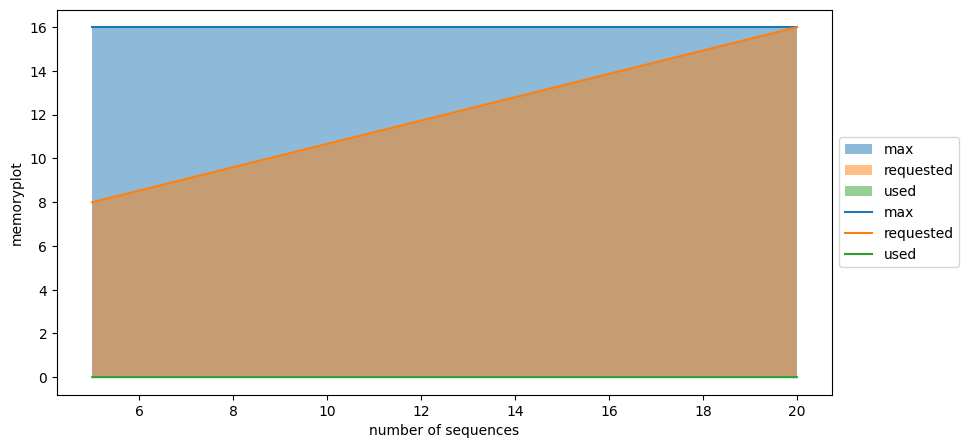

In [202]:
# i want to plot the memory used, requested and max  (as hue) vs the number of sequences
# transform the data to long format
x_axis = "n_sequences"
y_axis = "memoryplot"
df_plot = df_plot.sort_values(by=x_axis)
df_plot = df_plot[df_plot[y_axis].notnull()]

plt.figure(figsize=(10,5))
# Specify the order of types

types_order = ['max', 'requested', 'used']

for type in types_order:
    df_subset = df_plot[df_plot['type'] == type]
    plt.fill_between(df_subset[x_axis], df_subset[y_axis], alpha=0.5, label=type)
df_plot['type'] = pd.Categorical(df_plot['type'], categories=['max', 'requested', 'used'], ordered=True)

sns.lineplot(data=df_plot, x=x_axis, y=y_axis, hue="type")
# rename the x axis
plt.xlabel("number of sequences")
# put the legened outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))